## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
    * [4.2.Feature Selection](#3.2) 
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Machine Learning models-scikit-learn](#4.3.1)
        * [5.3.2 Time Series based Models-ARIMA and LSTM](#4.3.2)
* [6. Model Tuning and grid search](#5)
* [7. Finalise the model](#6)
    * [7.1. Result on the test dataset](#6.1)
    * [7.2. Save Model for Later Use](#6.2)     

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor  # ✅ Updated import

# Libraries for Statistical Models
import statsmodels.api as sm


# Libraries for Saving the Model
from pickle import dump, load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX  # Uncomment if needed

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Plotting 
# scatter_matrix already imported above
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

In [3]:
import yfinance as yf
import pandas as pd

# Define time period
start_date = '2010-01-01'
end_date = '2025-03-01'

# Define tickers
tickers = {
    'MSFT': 'MSFT',
    'IBM': 'IBM',
    'GOOGL': 'GOOGL',
    'S&P500': '^GSPC',
    'DOWJONES': '^DJI',
    'VIX': '^VIX',
    'USDJPY': 'JPY=X',
    'GBPUSD': 'GBPUSD=X'
}

# Fetch adjusted close prices (now using Close due to auto_adjust=True)
data = {}
for name, ticker in tickers.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        if not df.empty:
            data[name] = df['Close']
            print(f"✅ Downloaded: {name}")
        else:
            print(f"⚠️  Empty DataFrame for {name}")
    except Exception as e:
        print(f"❌ Error downloading {name}: {e}")

# If no data was downloaded, stop the process
if not data:
    raise ValueError("No valid data was downloaded. Exiting.")

# Combine all Series into a single DataFrame
combined_df = pd.concat(data.values(), axis=1)
combined_df.columns = list(data.keys())

# Make sure index is datetime
combined_df.index = pd.to_datetime(combined_df.index)

# Resample to weekly (Friday) and compute returns
weekly_returns = combined_df.resample('W-FRI').ffill().pct_change().dropna()

# Display result
print(weekly_returns.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


✅ Downloaded: MSFT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Downloaded: IBM
✅ Downloaded: GOOGL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Downloaded: S&P500
✅ Downloaded: DOWJONES


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Downloaded: VIX



[*********************100%***********************]  1 of 1 completed

✅ Downloaded: USDJPY
✅ Downloaded: GBPUSD
                MSFT       IBM     GOOGL    S&P500  DOWJONES       VIX  \
Date                                                                     
2010-01-15  0.006524  0.007107 -0.036577 -0.007817 -0.000804 -0.012135   
2010-01-22 -0.061569 -0.047655 -0.051707 -0.038969 -0.041158  0.524846   
2010-01-29 -0.026933 -0.024781 -0.036490 -0.016386 -0.010385 -0.098499   
2010-02-05 -0.005678  0.009232  0.002547 -0.007152 -0.005473  0.060520   
2010-02-12 -0.003212  0.008376  0.003444  0.008741  0.008680 -0.129452   

              USDJPY    GBPUSD  
Date                            
2010-01-15 -0.020613  0.015343  
2010-01-22 -0.010358 -0.009827  
2010-01-29  0.005122 -0.007769  
2010-02-05 -0.011632 -0.020449  
2010-02-12  0.008182  0.002559  


Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [4]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [5]:
# Target variable: MSFT future log return
Y = np.log(combined_df['MSFT']).diff(return_period).shift(-return_period)
Y.name = 'MSFT_pred'

# X1: GOOGL & IBM 5-day log returns
X1 = np.log(combined_df[['GOOGL', 'IBM']]).diff(return_period)

# X2: Currencies
X2 = np.log(combined_df[['USDJPY', 'GBPUSD']]).diff(return_period)

# X3: Indices
X3 = np.log(combined_df[['S&P500', 'DOWJONES', 'VIX']]).diff(return_period)

# X4: MSFT lag features (5d, 15d, 30d, 60d)
X4 = pd.concat(
    [np.log(combined_df['MSFT']).diff(i) for i in [5, 15, 30, 60]],
    axis=1
)
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

# Combine all features
X = pd.concat([X1, X2, X3, X4], axis=1)

# Merge target and features, downsample every 5th business day
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]

# Final X and Y
Y = dataset[Y.name]
X = dataset.drop(columns=Y.name)

print(X.head())
print(Y.head())

               GOOGL       IBM    USDJPY    GBPUSD    S&P500  DOWJONES  \
Date                                                                     
2010-03-30  0.031749 -0.004649  0.026794  0.003506 -0.000767  0.001706   
2010-04-07 -0.006333  0.001792 -0.002259  0.003834  0.011072  0.003759   
2010-04-16 -0.028792  0.014419 -0.010901 -0.000384 -0.001877  0.001936   
2010-04-26 -0.034133 -0.011408  0.015454  0.008609  0.012060  0.010134   
2010-05-03 -0.001958 -0.008682  0.008399 -0.014237 -0.008110 -0.004759   

                 VIX   MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
Date                                                           
2010-03-30  0.046603 -0.003688  0.033126  0.048874  -0.034530  
2010-04-07 -0.056724  0.002046 -0.009495  0.024837  -0.028839  
2010-04-16  0.128874  0.010818  0.033486  0.070228   0.062035  
2010-04-26  0.007469  0.002252  0.060966  0.060283   0.095453  
2010-05-03  0.144702 -0.008068  0.017654  0.041687   0.111972  
Date
2010-03-30   -0.015231
2010-

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [6]:
# Set display precision to 3 decimal places
pd.set_option('display.precision', 3)

# Show summary statistics
dataset.describe()


,MSFT_pred,GOOGL,IBM,USDJPY,GBPUSD,S&P500,DOWJONES,VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,630.000,630.000,630.000,6.300e+02,6.300e+02,630.000,630.000,630.000,630.000,630.000,630.000,630.000
mean,0.003,0.005,0.002,8.760e-04,-6.172e-04,0.003,0.003,-0.002,0.005,0.013,0.025,0.048
std,0.031,0.036,0.031,1.281e-02,1.274e-02,0.021,0.020,0.148,0.031,0.052,0.068,0.092
min,-0.155,-0.132,-0.129,-5.370e-02,-9.768e-02,-0.133,-0.140,-0.434,-0.131,-0.198,-0.249,-0.274
25%,-0.016,-0.017,-0.013,-6.275e-03,-7.642e-03,-0.006,-0.007,-0.087,-0.013,-0.019,-0.019,-0.011
50%,0.004,0.006,0.002,7.762e-04,-9.794e-04,0.004,0.003,-0.017,0.007,0.017,0.029,0.055
75%,0.021,0.025,0.019,8.282e-03,6.725e-03,0.014,0.014,0.074,0.025,0.046,0.067,0.111
max,0.113,0.174,0.159,7.042e-02,5.963e-02,0.098,0.121,0.781,0.142,0.169,0.274,0.333


In [7]:
dataset.head()

,MSFT_pred,GOOGL,IBM,USDJPY,GBPUSD,S&P500,DOWJONES,VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,,,,,,,,,,
2010-03-30,-0.015,0.032,-0.005,0.027,3.506e-03,-7.668e-04,0.002,0.047,-0.004,0.033,0.049,-0.035
2010-04-07,0.049,-0.006,0.002,-0.002,3.834e-03,1.107e-02,0.004,-0.057,0.002,-0.009,0.025,-0.029
2010-04-16,0.009,-0.029,0.014,-0.011,-3.842e-04,-1.877e-03,0.002,0.129,0.011,0.033,0.070,0.062
2010-04-26,-0.008,-0.034,-0.011,0.015,8.609e-03,1.206e-02,0.010,0.007,0.002,0.061,0.060,0.095
2010-05-03,-0.064,-0.002,-0.009,0.008,-1.424e-02,-8.110e-03,-0.005,0.145,-0.008,0.018,0.042,0.112


In [8]:
# Check missing values
print("Missing values in features:\n", X.isnull().sum())
print("Missing values in target:\n", Y.isnull().sum())


Missing values in features:
 GOOGL        0
IBM          0
USDJPY       0
GBPUSD       0
S&P500       0
DOWJONES     0
VIX          0
MSFT_DT      0
MSFT_3DT     0
MSFT_6DT     0
MSFT_12DT    0
dtype: int64
Missing values in target:
 0


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

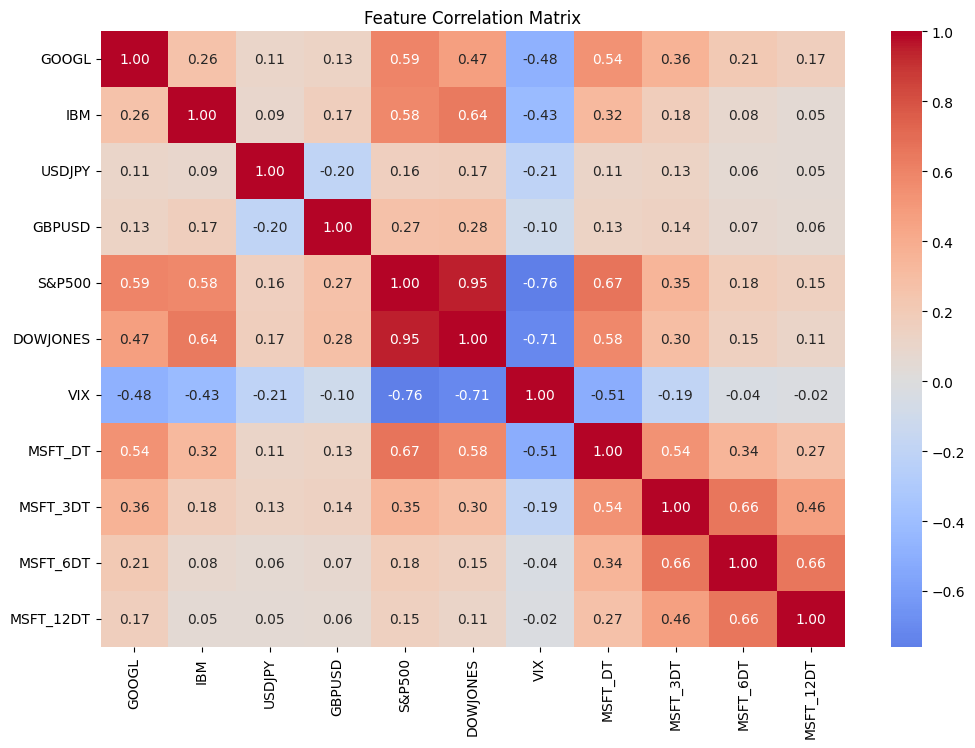

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()


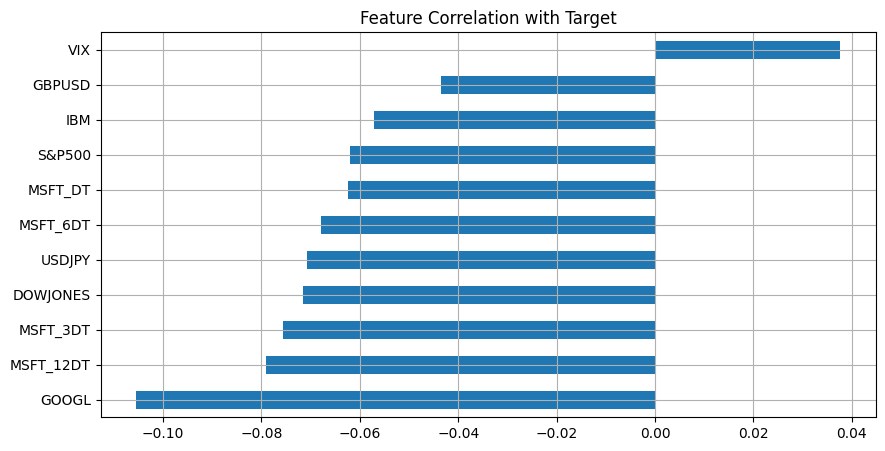

In [10]:
correlation_with_target = X.corrwith(Y)
correlation_with_target.sort_values().plot(kind='barh', figsize=(10, 5), title="Feature Correlation with Target")
plt.grid(True)
plt.show()


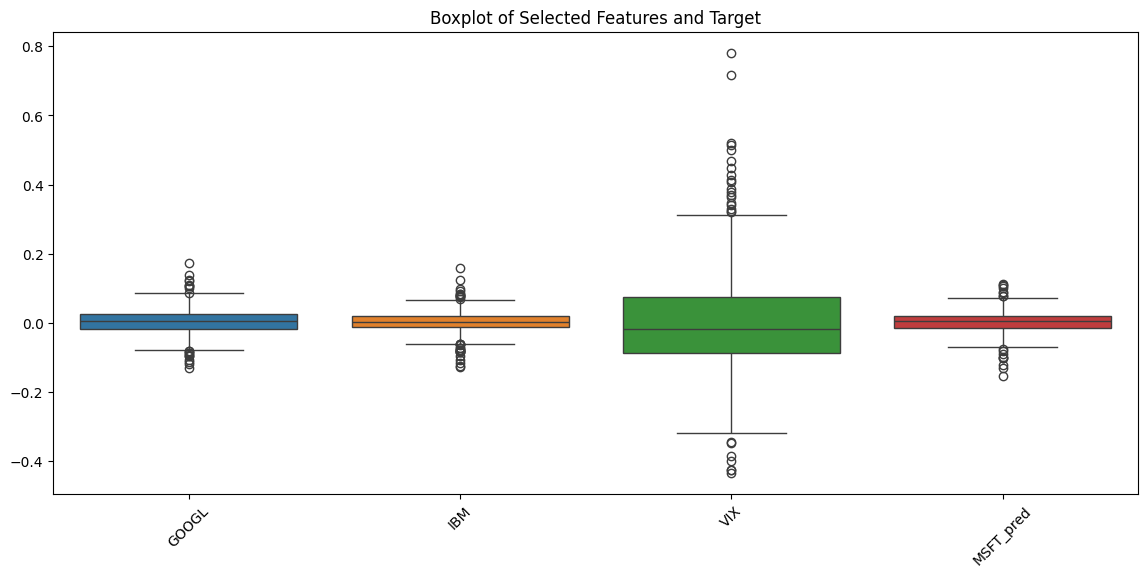

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.boxplot(data=dataset[['GOOGL', 'IBM', 'VIX', 'MSFT_pred']])
plt.title("Boxplot of Selected Features and Target")
plt.xticks(rotation=45)
plt.show()


In [12]:
print(X.columns)


Index(['GOOGL', 'IBM', 'USDJPY', 'GBPUSD', 'S&P500', 'DOWJONES', 'VIX',
       'MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT'],
      dtype='object')


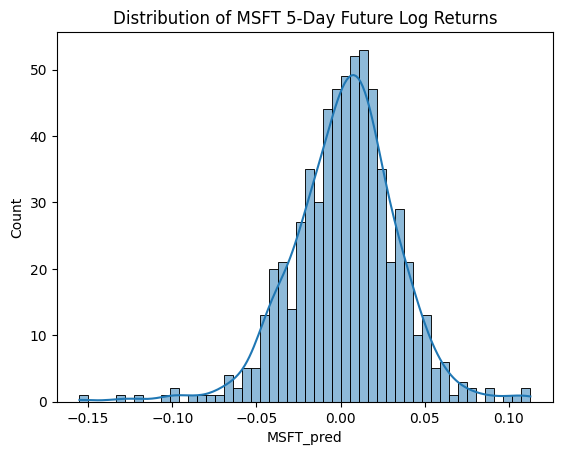

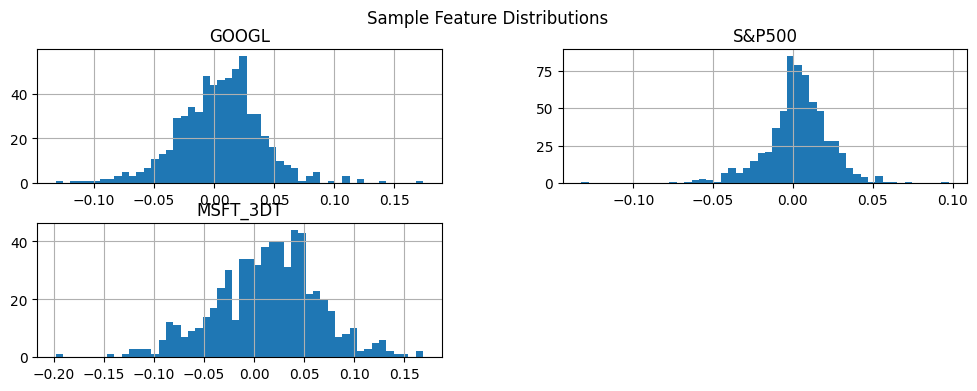

In [13]:
# Target distribution
sns.histplot(Y, bins=50, kde=True)
plt.title("Distribution of MSFT 5-Day Future Log Returns")
plt.show()

# Distribution of actual column names from X
X[['GOOGL', 'S&P500', 'MSFT_3DT']].hist(bins=50, figsize=(12, 4))
plt.suptitle("Sample Feature Distributions")
plt.show()


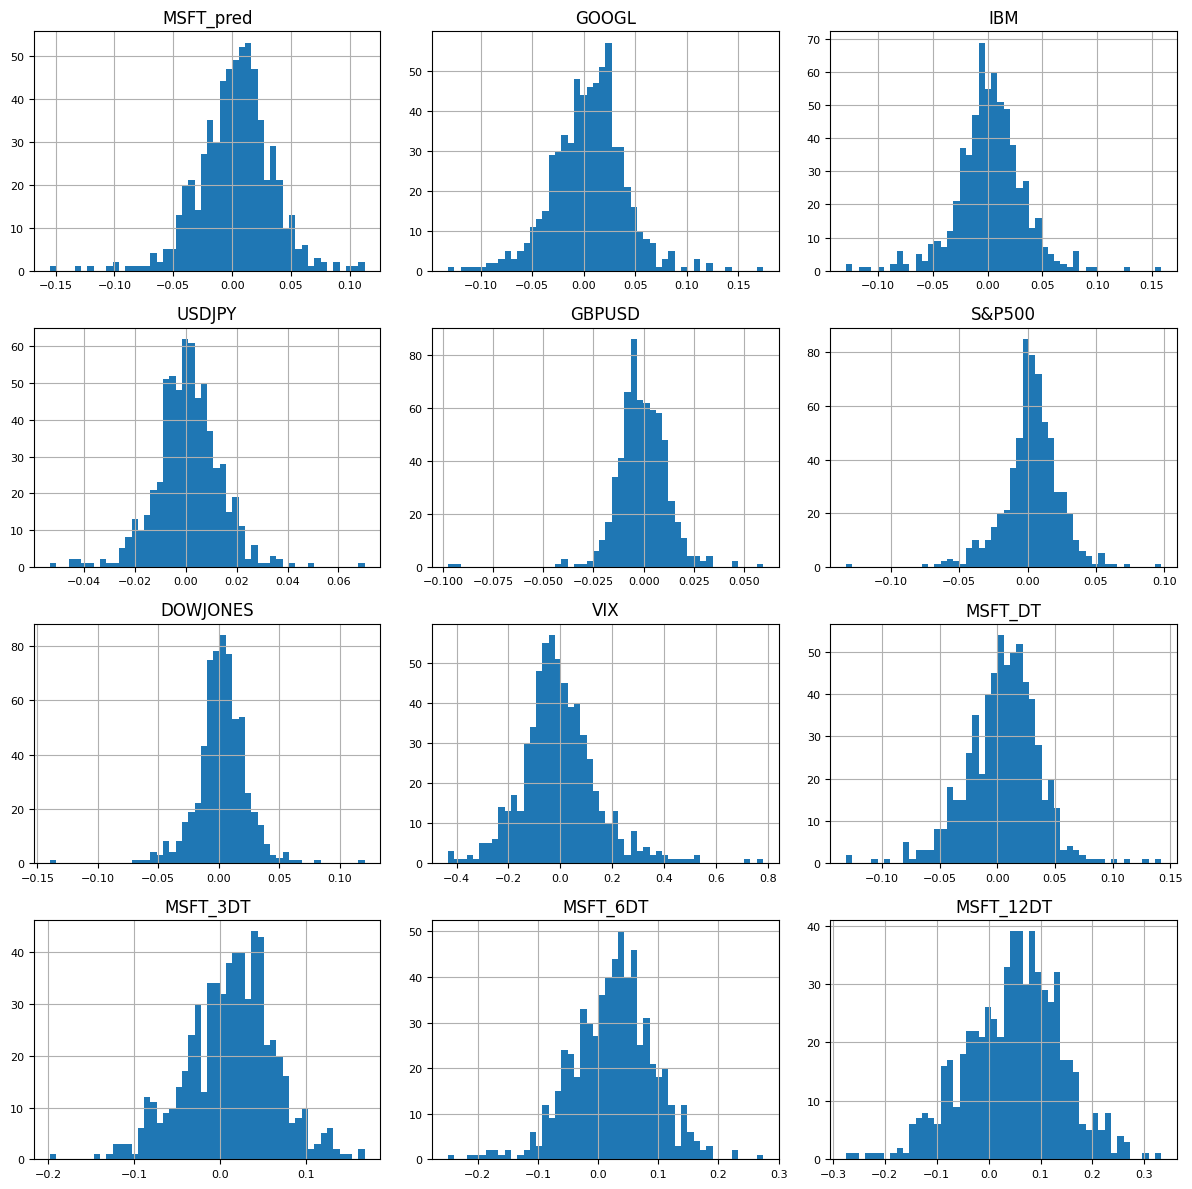

In [14]:
import matplotlib.pyplot as plt  # in case it’s not already imported

dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=8, ylabelsize=8, figsize=(12,12))
plt.tight_layout()
plt.show()


The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

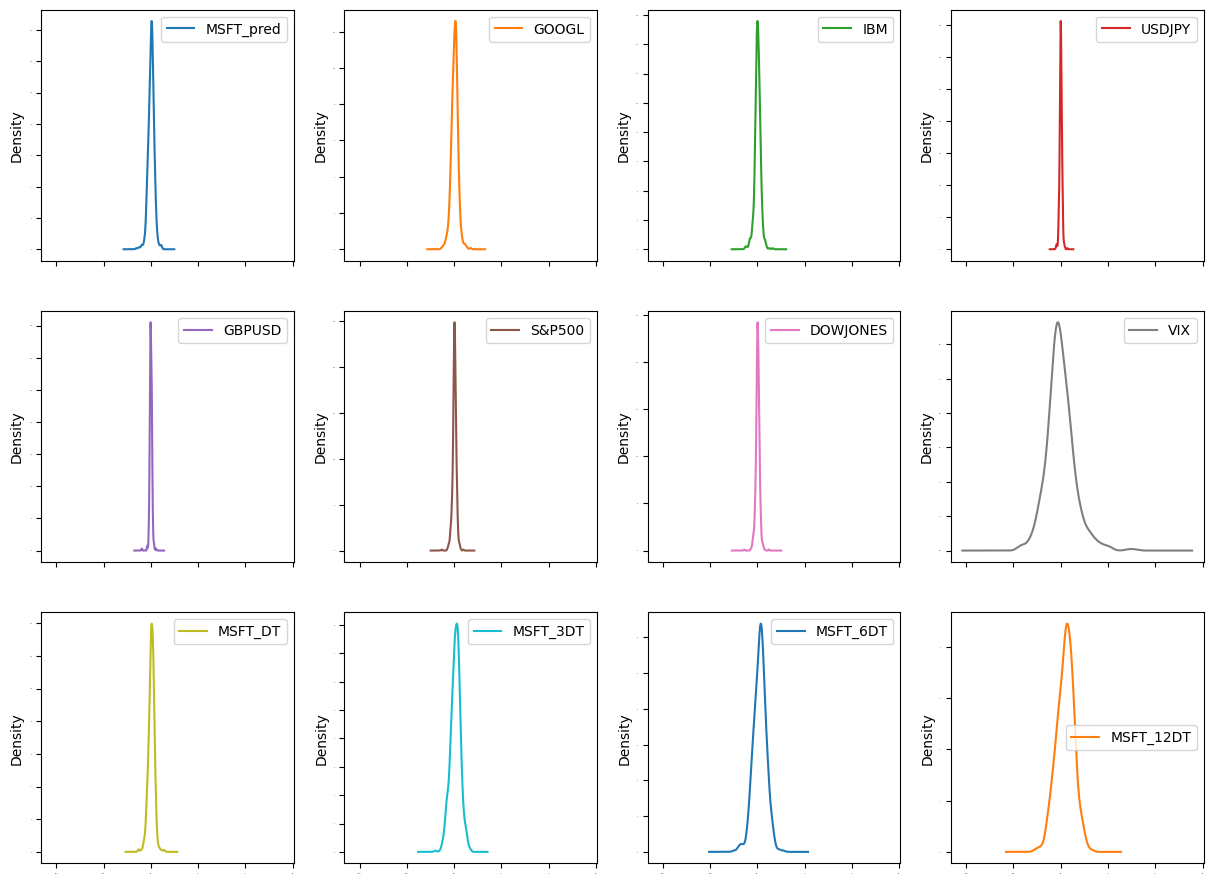

In [15]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()  # use plt instead of pyplot if you've imported it that way


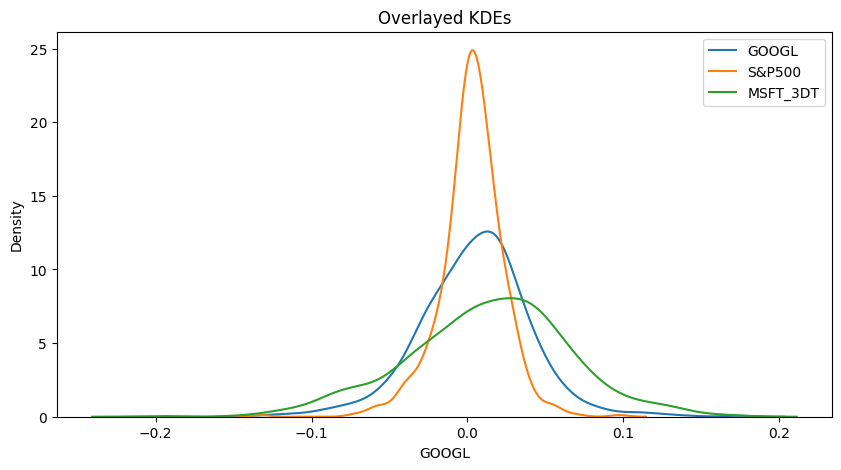

In [16]:
import seaborn as sns

plt.figure(figsize=(10, 5))
for col in ['GOOGL', 'S&P500', 'MSFT_3DT']:
    sns.kdeplot(dataset[col], label=col)
plt.legend()
plt.title("Overlayed KDEs")
plt.show()


We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

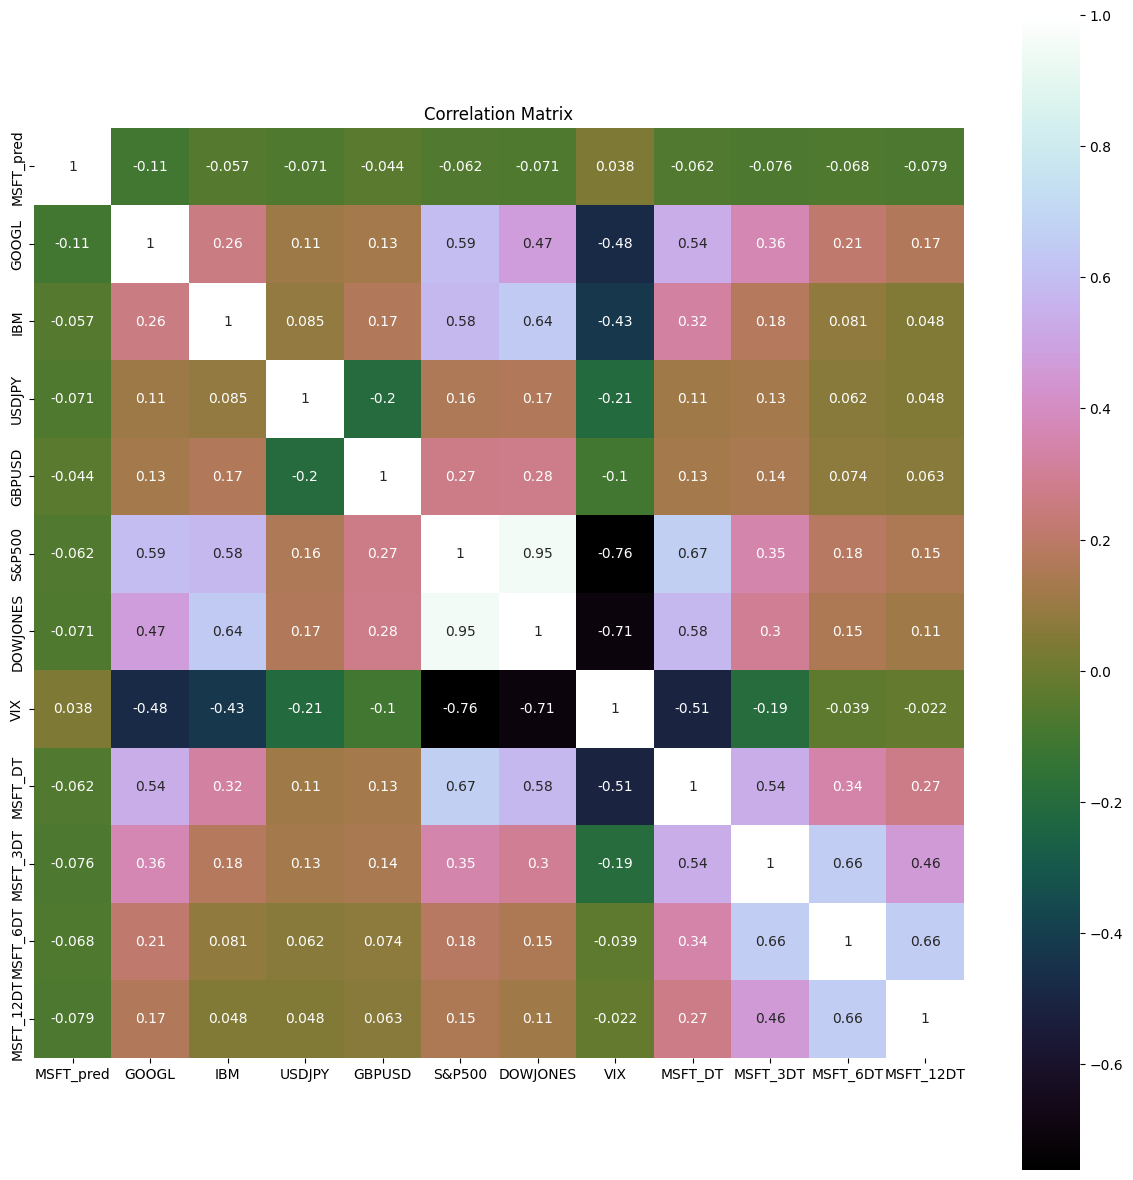

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt  # make sure this import is present

# Compute correlation matrix
correlation = dataset.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.show()


Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1500x1500 with 0 Axes>

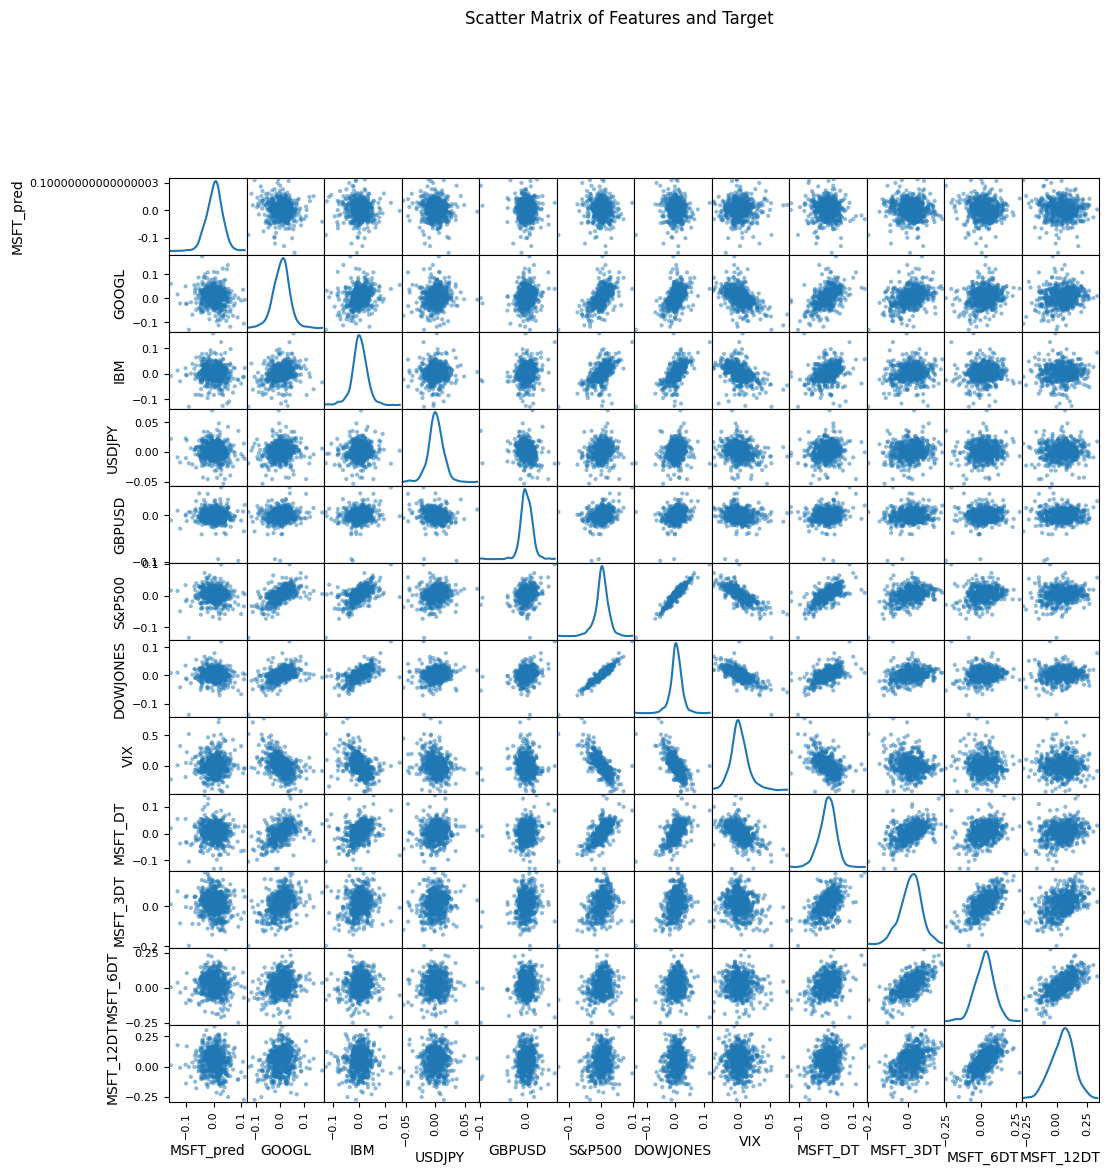

In [18]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

plt.figure(figsize=(15, 15))  # Optional: placeholder figure (not strictly needed)
scatter_matrix(dataset, figsize=(12, 12), diagonal='kde')
plt.suptitle("Scatter Matrix of Features and Target", y=1.02)
plt.show()


Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

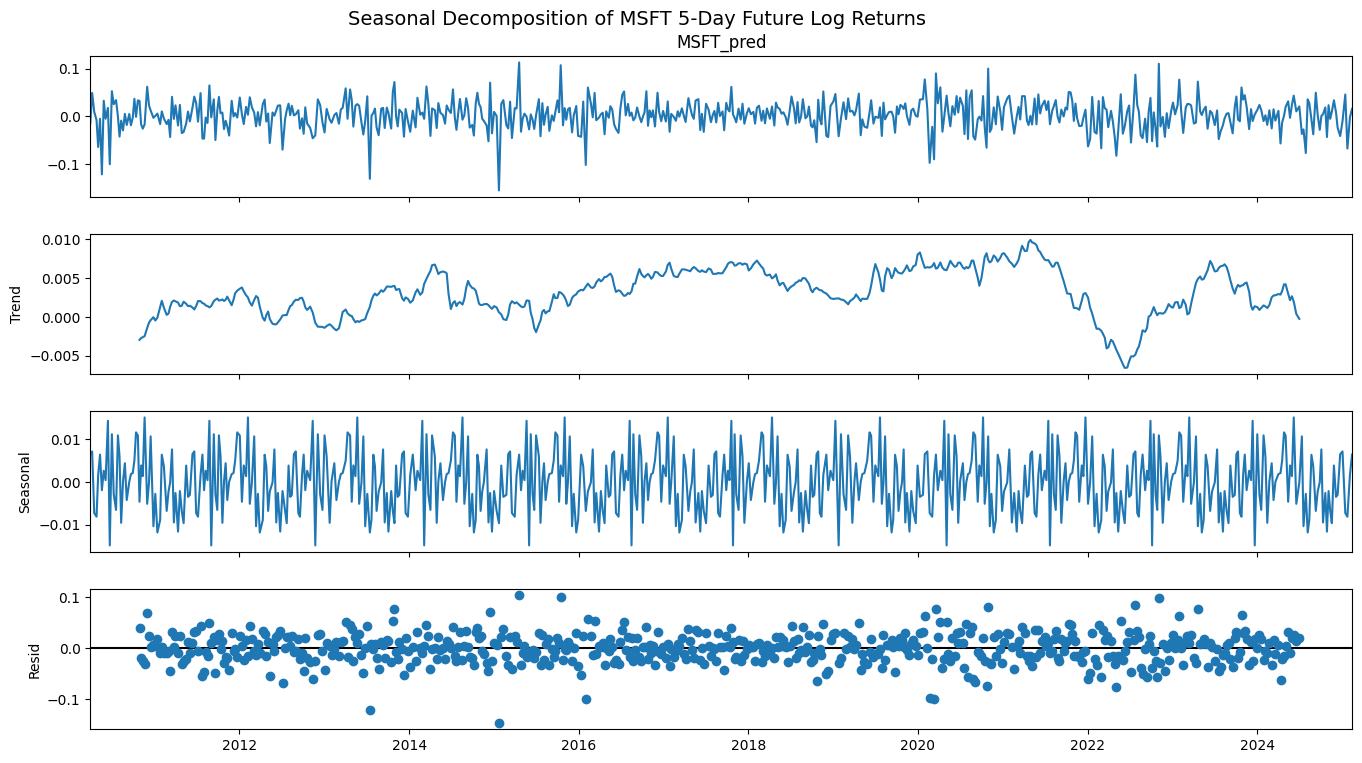

In [19]:
# Decompose the time series (assuming weekly frequency and yearly pattern)
res = sm.tsa.seasonal_decompose(Y, period=52)

# Plot decomposition
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.suptitle("Seasonal Decomposition of MSFT 5-Day Future Log Returns", fontsize=14)
plt.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

# Apply SelectKBest
selector = SelectKBest(score_func=f_regression, k='all')  # or set k=5 for top 5
X_selected = selector.fit(X, Y)

# Get feature scores and p-values
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_score': X_selected.scores_,
    'p_value': X_selected.pvalues_
})

# Sort by F-score (higher = more predictive power)
feature_scores = feature_scores.sort_values(by='F_score', ascending=False)

print(feature_scores)


      Feature  F_score  p_value
0       GOOGL    7.071    0.008
10  MSFT_12DT    3.953    0.047
8    MSFT_3DT    3.608    0.058
5    DOWJONES    3.224    0.073
2      USDJPY    3.157    0.076
9    MSFT_6DT    2.908    0.089
7     MSFT_DT    2.457    0.118
4      S&P500    2.421    0.120
1         IBM    2.050    0.153
3      GBPUSD    1.195    0.275
6         VIX    0.893    0.345


In [21]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
GOOGL,7.071
MSFT_12DT,3.953
MSFT_3DT,3.608
DOWJONES,3.224
USDJPY,3.157
MSFT_6DT,2.908
MSFT_DT,2.457
S&P500,2.421
IBM,2.050


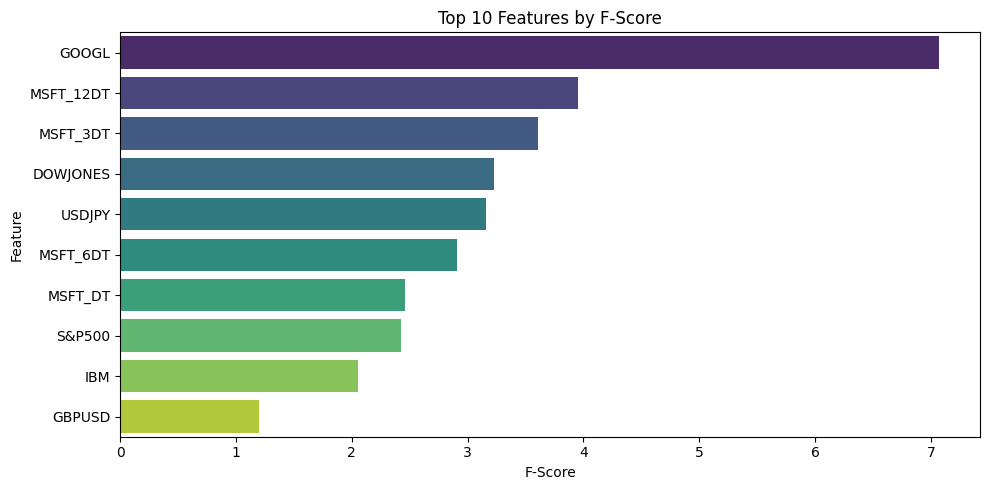

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = featureScores.nlargest(10, 'Score')
plt.figure(figsize=(10, 5))
sns.barplot(data=top_features, x='Score', y='Specs', palette='viridis')
plt.title('Top 10 Features by F-Score')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


We see that IBM seems to be the most important feature and vix being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [23]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

Training set: (504, 11), Testing set: (126, 11)


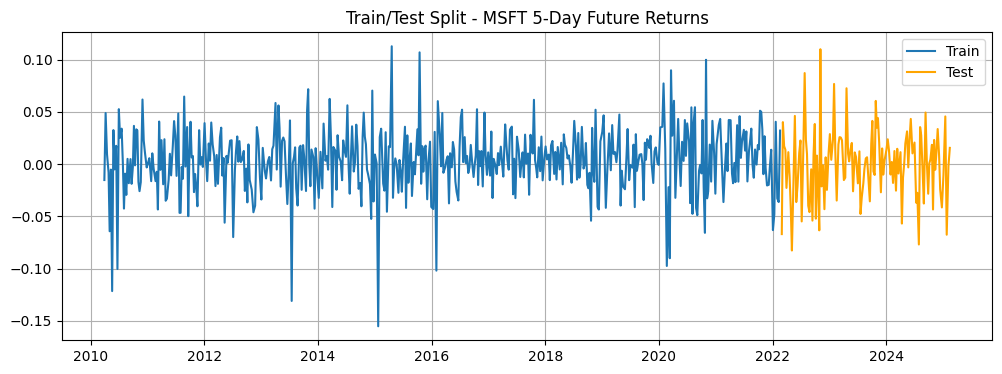

In [24]:
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Optional: visualize target over time with split
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(Y_train, label='Train')
plt.plot(Y_test, label='Test', color='orange')
plt.title("Train/Test Split - MSFT 5-Day Future Returns")
plt.legend()
plt.grid(True)
plt.show()


<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [25]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [26]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [27]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [28]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    # K-Fold CV
    kfold = KFold(n_splits=num_folds, shuffle=False) # shuffle=False for time series
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Fit on full training data
    model.fit(X_train, Y_train)
    
    # Train performance
    y_train_pred = model.predict(X_train)
    train_rmse = mean_squared_error(Y_train, y_train_pred, squared=False)
    train_results.append(train_rmse)
    
    # Test performance
    y_test_pred = model.predict(X_test)
    test_rmse = mean_squared_error(Y_test, y_test_pred, squared=False)
    test_results.append(test_rmse)
    
    # Output
    print(f"{name}: CV RMSE = {cv_results.mean():.4f} (±{cv_results.std():.4f}) | "
          f"Train RMSE = {train_rmse:.4f} | Test RMSE = {test_rmse:.4f}")


LR: CV RMSE = 0.0010 (±0.0005) | Train RMSE = 0.0304 | Test RMSE = 0.0329
LASSO: CV RMSE = 0.0010 (±0.0005) | Train RMSE = 0.0308 | Test RMSE = 0.0331
EN: CV RMSE = 0.0010 (±0.0005) | Train RMSE = 0.0308 | Test RMSE = 0.0331
KNN: CV RMSE = 0.0012 (±0.0005) | Train RMSE = 0.0278 | Test RMSE = 0.0343
CART: CV RMSE = 0.0022 (±0.0010) | Train RMSE = 0.0000 | Test RMSE = 0.0481
SVR: CV RMSE = 0.0014 (±0.0005) | Train RMSE = 0.0370 | Test RMSE = 0.0379
MLP: CV RMSE = 0.0011 (±0.0006) | Train RMSE = 0.0323 | Test RMSE = 0.0355
ABR: CV RMSE = 0.0010 (±0.0005) | Train RMSE = 0.0264 | Test RMSE = 0.0333
GBR: CV RMSE = 0.0012 (±0.0005) | Train RMSE = 0.0185 | Test RMSE = 0.0356
RFR: CV RMSE = 0.0011 (±0.0004) | Train RMSE = 0.0124 | Test RMSE = 0.0340
ETR: CV RMSE = 0.0011 (±0.0005) | Train RMSE = 0.0000 | Test RMSE = 0.0332


#### K Fold results

We being by looking at the K Fold results

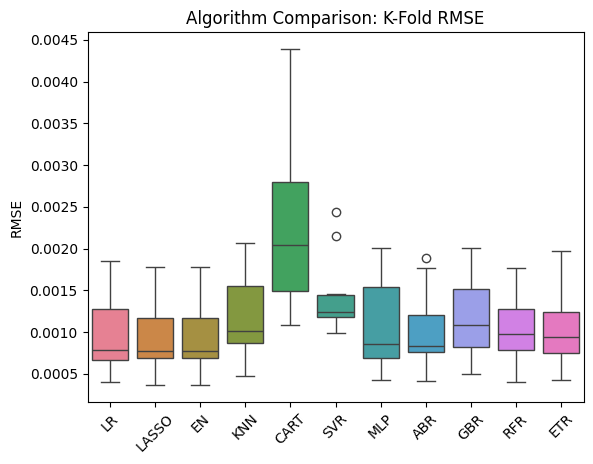

In [30]:
import seaborn as sns
import pandas as pd

# Flatten results into long DataFrame
kfold_df = pd.DataFrame({name: result for name, result in zip(names, kfold_results)})
sns.boxplot(data=kfold_df)
plt.title("Algorithm Comparison: K-Fold RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

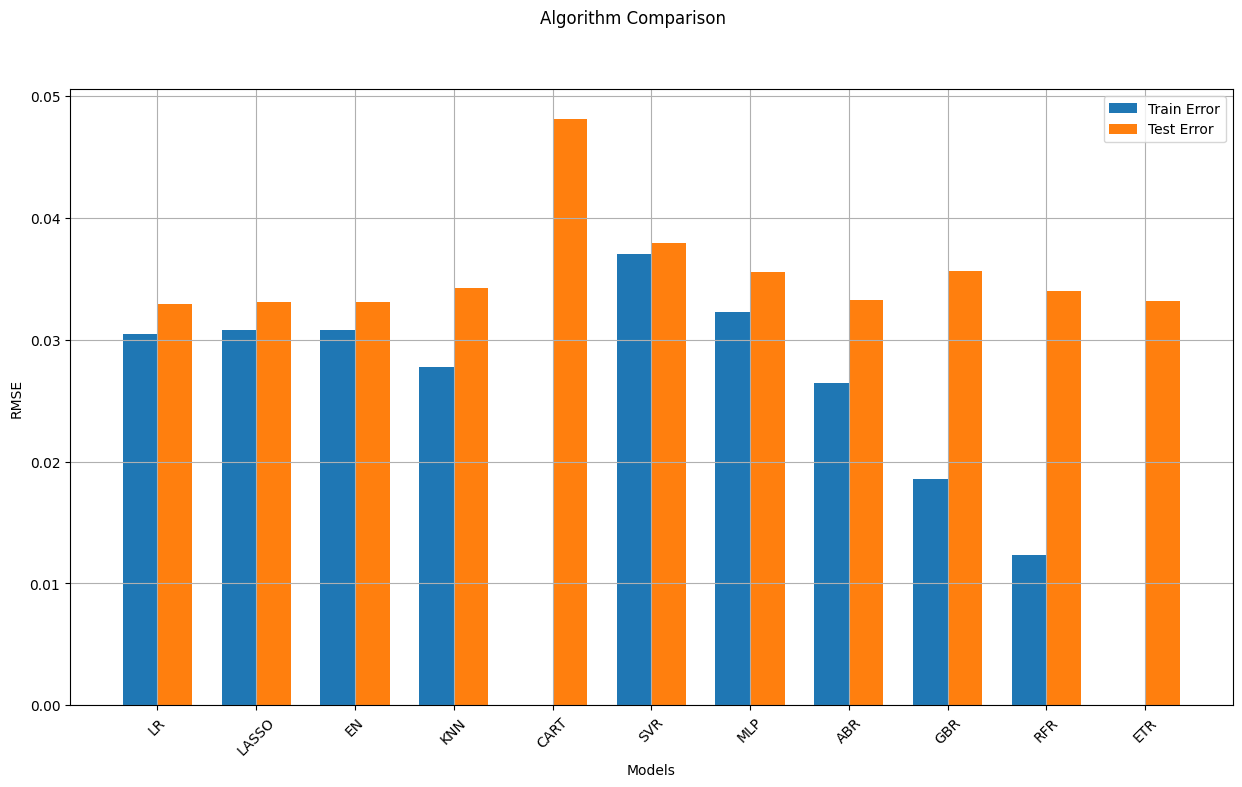

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
fig.suptitle('Algorithm Comparison')

ind = np.arange(len(names))  # x locations
width = 0.35  # bar width

ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results, width=width, label='Train Error')
plt.bar(ind + width/2, test_results,  width=width, label='Test Error')

fig.set_size_inches(15, 8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.grid(True)

plt.show()


Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [32]:
print(X_train.columns.tolist())


['GOOGL', 'IBM', 'USDJPY', 'GBPUSD', 'S&P500', 'DOWJONES', 'VIX', 'MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']


In [33]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'USDJPY', 'S&P500', 'DOWJONES', 'VIX']]
X_test_ARIMA  = X_test.loc[:,  ['GOOGL', 'IBM', 'USDJPY', 'S&P500', 'DOWJONES', 'VIX']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [35]:
# Training error
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)

# Predict on test set
predicted = model_fit.predict(
    start=len(Y_train), 
    end=len(Y_train) + len(Y_test) - 1, 
    exog=X_test_ARIMA
)

# Testing error
error_Test_ARIMA = mean_squared_error(Y_test, predicted)
print(f"SARIMAX Test RMSE: {error_Test_ARIMA:.4f}")


SARIMAX Test RMSE: 0.0011


###  LSTM Model

In [36]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD

def create_LSTMmodel(neurons=50, learn_rate=0.01, momentum=0.0):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# Create and train the model
LSTMModel = create_LSTMmodel(neurons=50, learn_rate=0.01, momentum=0.0)
LSTMModel_fit = LSTMModel.fit(
    X_train_LSTM, Y_train_LSTM,
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330,
    batch_size=72,
    verbose=0,
    shuffle=False
)


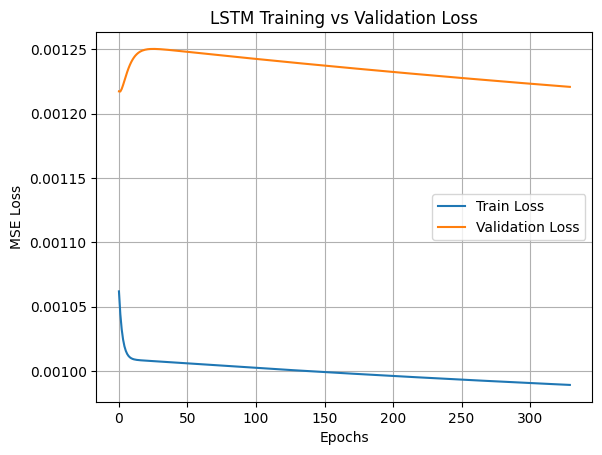

In [38]:
import matplotlib.pyplot as plt

plt.plot(LSTMModel_fit.history['loss'], label='Train Loss')
plt.plot(LSTMModel_fit.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


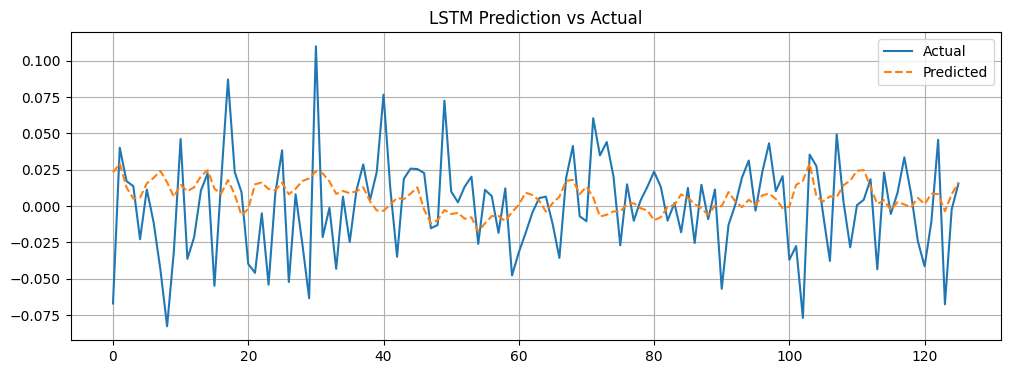

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(Y_test_LSTM, label="Actual")
plt.plot(predicted, label="Predicted", linestyle="--")
plt.title("LSTM Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()


#### Append to previous results

In [41]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

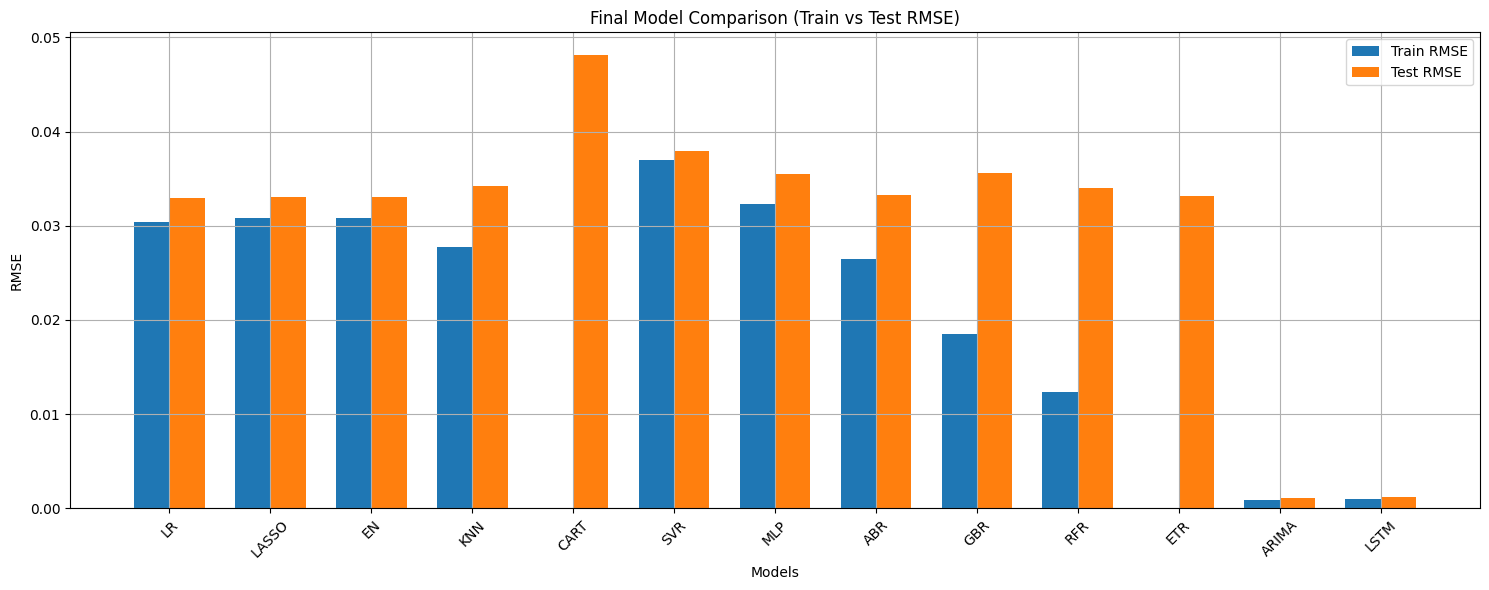

In [42]:
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(len(names))  # x locations
width = 0.35

fig, ax = plt.subplots(figsize=(15, 6))
plt.title('Final Model Comparison (Train vs Test RMSE)')

# Plot bars
plt.bar(ind - width/2, train_results, width=width, label='Train RMSE')
plt.bar(ind + width/2, test_results, width=width, label='Test RMSE')

# Labels and ticks
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Overall Comparison of all the algorithms ( including Time Series Algorithms)

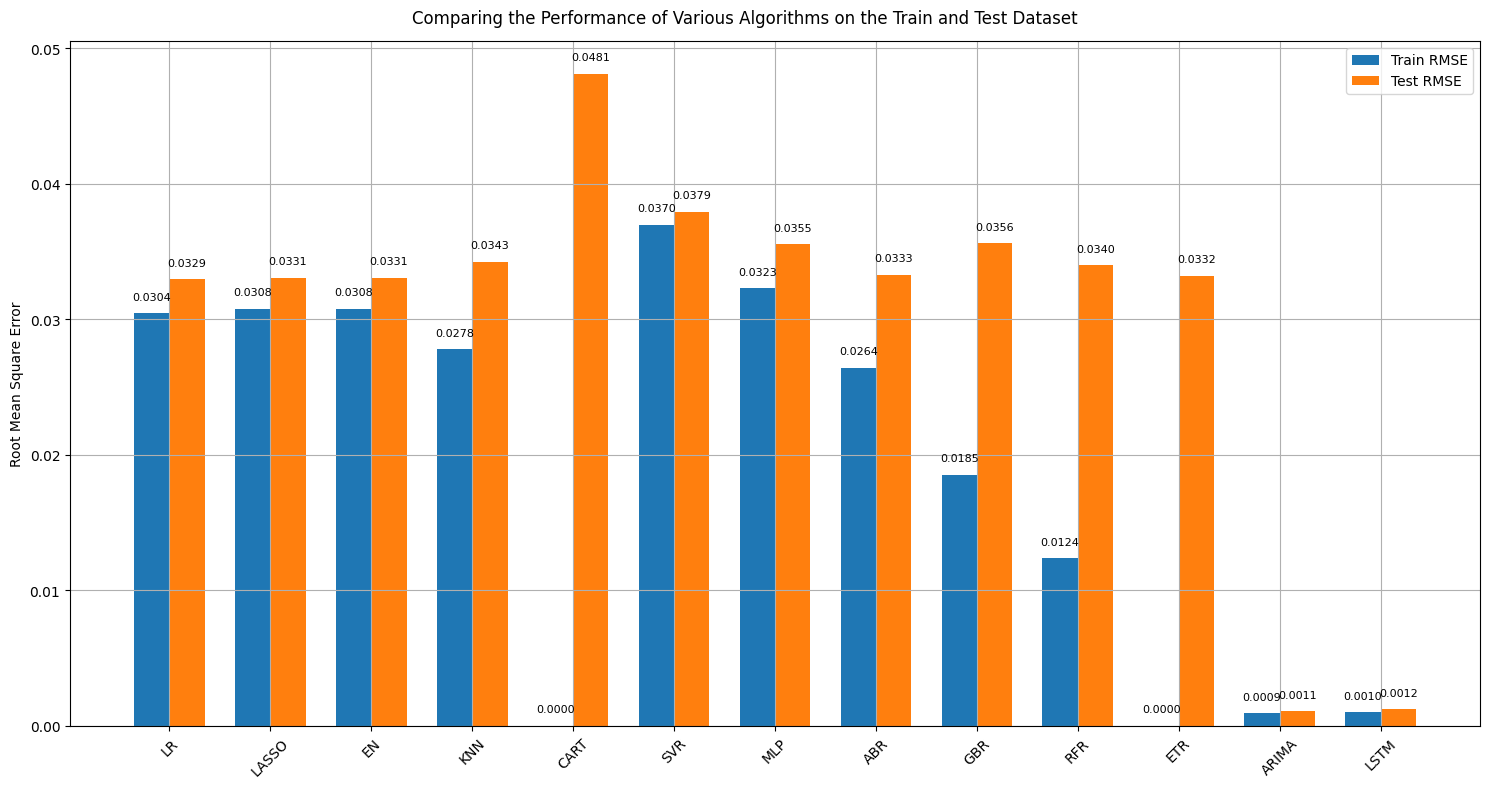

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Comparing the Performance of Various Algorithms on the Train and Test Dataset')

# Bar width and positions
ind = np.arange(len(names))
width = 0.35

# Plot bars
ax.bar(ind - width/2, train_results, width=width, label='Train RMSE')
ax.bar(ind + width/2, test_results, width=width, label='Test RMSE')
for i, v in enumerate(train_results):
    ax.text(i - width/2, v + 0.001, f"{v:.4f}", ha='center', fontsize=8)
for i, v in enumerate(test_results):
    ax.text(i + width/2, v + 0.001, f"{v:.4f}", ha='center', fontsize=8)

# Labels and formatting
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel('Root Mean Square Error')
ax.legend()
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [44]:
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluate a single ARIMA model
def evaluate_arima_model(arima_order):
    model = SARIMAX(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = model.fit(disp=False)
    rmse = mean_squared_error(Y_train, model_fit.fittedvalues, squared=False)
    return rmse

# Grid search over p, d, q
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(order)
                    print(f'ARIMA{order} RMSE = {rmse:.7f}')
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(f'ARIMA{order} failed: {e}')
                    continue
    print(f'\n✅ Best ARIMA{best_cfg} RMSE = {best_score:.7f}')

# Parameters to evaluate
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE = 0.0308020
ARIMA(0, 0, 1) RMSE = 0.0306537
ARIMA(0, 1, 0) RMSE = 0.0434646
ARIMA(0, 1, 1) RMSE = 0.0310324
ARIMA(1, 0, 0) RMSE = 0.0306618
ARIMA(1, 0, 1) RMSE = 0.0306483
ARIMA(1, 1, 0) RMSE = 0.0380313
ARIMA(1, 1, 1) RMSE = 0.0315565
ARIMA(2, 0, 0) RMSE = 0.0306535
ARIMA(2, 0, 1) RMSE = 0.0306529
ARIMA(2, 1, 0) RMSE = 0.0359832
ARIMA(2, 1, 1) RMSE = 0.0311066

✅ Best ARIMA(1, 0, 1) RMSE = 0.0306483


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [45]:
best_model = SARIMAX(Y_train, exog=X_train_ARIMA, order=(1,0,1))
best_fit = best_model.fit(disp=False)

forecast = best_fit.predict(
    start=len(Y_train),
    end=len(Y_train) + len(Y_test) - 1,
    exog=X_test_ARIMA
)

from sklearn.metrics import mean_squared_error
rmse_test = mean_squared_error(Y_test, forecast, squared=False)
print(f"Test RMSE for ARIMA(1,0,1): {rmse_test:.4f}")


Test RMSE for ARIMA(1,0,1): 0.0332


In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare model using best-tuned parameters
modelARIMA_tuned = SARIMAX(endog=Y_train, exog=X_train_ARIMA, order=(1, 0, 1))
model_fit_tuned = modelARIMA_tuned.fit(disp=False)



In [47]:
# Forecast on test set using the tuned model
predicted_tuned = model_fit_tuned.predict(
    start=len(Y_train),
    end=len(Y_train) + len(Y_test) - 1,
    exog=X_test_ARIMA
)

# Evaluate Test RMSE
from sklearn.metrics import mean_squared_error
rmse_tuned = mean_squared_error(Y_test, predicted_tuned, squared=False)
print(f"Tuned ARIMA(1,0,1) Test RMSE: {rmse_tuned:.4f}")


Tuned ARIMA(1,0,1) Test RMSE: 0.0332


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [48]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

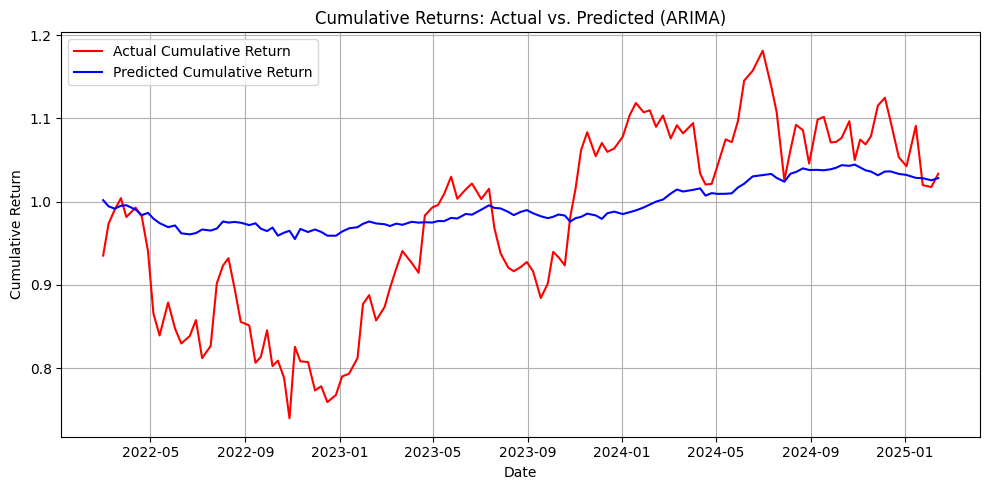

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Align prediction index with Y_test
predicted_tuned.index = Y_test.index

# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(np.exp(Y_test).cumprod(), 'r', label='Actual Cumulative Return')
plt.plot(np.exp(predicted_tuned).cumprod(), 'b', label='Predicted Cumulative Return')

plt.title("Cumulative Returns: Actual vs. Predicted (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# Align LSTM predictions index to match Y_test
Y_test_LSTM = Y_test[seq_len - 1:]  # remove the first (seq_len - 1) samples
predicted_LSTM = predicted[:len(Y_test_LSTM)]

# Apply the same index to LSTM predictions
predicted_LSTM = pd.Series(predicted_LSTM.flatten(), index=Y_test_LSTM.index)


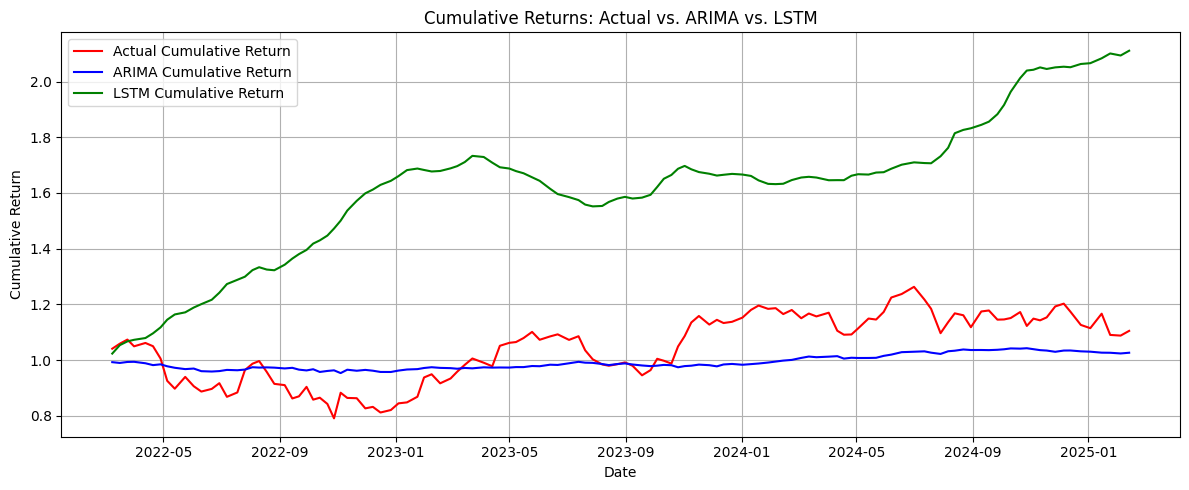

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cumulative return calculations
actual_cum = np.exp(Y_test_LSTM).cumprod()
arima_cum = np.exp(predicted_tuned[Y_test_LSTM.index]).cumprod()
lstm_cum = np.exp(predicted_LSTM).cumprod()

# Plot all
plt.figure(figsize=(12, 5))
plt.plot(actual_cum, 'r', label='Actual Cumulative Return')
plt.plot(arima_cum, 'b', label='ARIMA Cumulative Return')
plt.plot(lstm_cum, 'g', label='LSTM Cumulative Return')

# Annotations
plt.title("Cumulative Returns: Actual vs. ARIMA vs. LSTM")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
print(f"Actual Return: {actual_cum.iloc[-1] - 1:.2%}")
print(f"ARIMA Return: {arima_cum.iloc[-1] - 1:.2%}")
print(f"LSTM Return: {lstm_cum.iloc[-1] - 1:.2%}")


Actual Return: 10.50%
ARIMA Return: 2.64%
LSTM Return: 111.06%


### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promis‐
ing modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.